In [1]:
%load_ext lab_black

# Historic Events

In this notebook we plot historic cold spells in Texas to show their intensity and duration.
We'll use the ERA5 data, for consistency with the "local_return_period" analysis.

In [2]:
import cartopy.crs as ccrs
from cartopy.feature import STATES, COASTLINE
from datetime import datetime
import matplotlib.pyplot as plt
import regionmask
import numpy as np
import xarray as xr

from codebase.fig import figname

We start by loading the data. We'll slice off the most Southern tip of Texas, which doesn't get as cold, and the Western sliver (much love to my friends in El Paso, but you're not in ERCOT)

In [3]:
DURATIONS = [1, 3, 5]
Xi, Xf = (-106, -92)
Yi, Yf = (27, 37)

In [4]:
hdd = (
    xr.open_mfdataset("../data/processed/era5/hdd_*.nc")
    .sel(latitude=slice(Yf, Yi), longitude=slice(Xi, Xf))
    .compute()
)

In [5]:
hdd_roll = xr.concat(
    [
        hdd["HDD"].rolling(time=dur).mean().assign_coords({"lag": dur})
        for dur in DURATIONS
    ],
    dim="lag",
).rename(
    {"longitude": "lon", "latitude": "lat"}
)  # rename to work w/ regionmask

Based on **subjective** exploratory analysis, reading newspapers and blogs, and looking at this data, we choose 4 events to plot

In [6]:
EVENTS = [
    ["1951-02-01", "1951-02-01", "1951-02-02"],  # 1 day, 3 day, 5 day
    ["1983-12-25", "1983-12-25", "1983-12-26"],
    ["1989-12-23", "1989-12-24", "1989-12-24"],
    ["2011-02-02", "2011-02-04", "2011-02-05"],
    ["2021-02-15", "2021-02-16", "2021-02-16"],
]

**NOTE**: not all data for 2021 is available yet!

We'll plot heating demand days centered on Texas, but we'll include nearby regions

In [7]:
data_proj = ccrs.PlateCarree()
map_proj = ccrs.LambertConformal()
plot_kw = {
    "levels": np.linspace(33, 68, 15),
    "cmap": "plasma",
    "add_colorbar": False,
    "transform": data_proj,
}

We apply a filter to show only data over land

In [8]:
countries = regionmask.defined_regions.natural_earth.countries_110
mask = countries.mask(hdd_roll)
usa_idx = countries.map_keys("United States of America")
mexico_idx = countries.map_keys("Mexico")
hdd_land = hdd_roll.where(np.logical_or(mask == usa_idx, mask == mexico_idx))

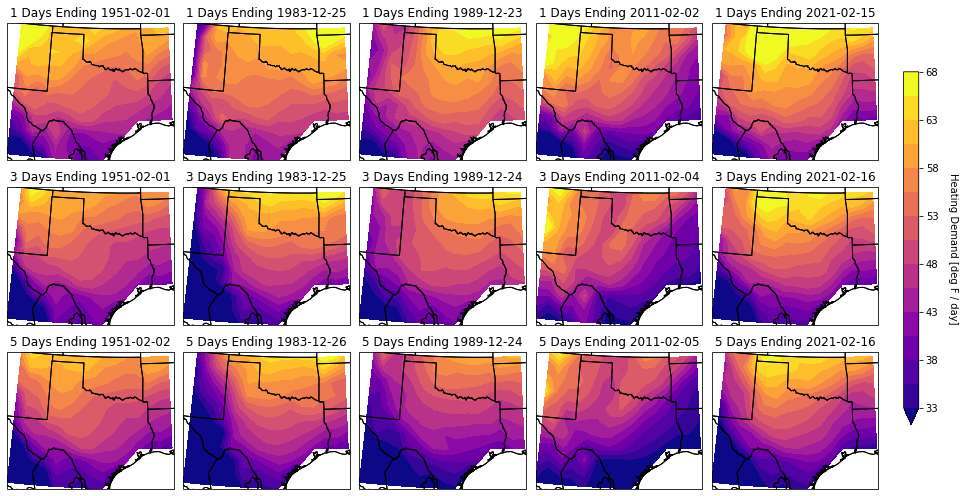

In [9]:
fig, axes = plt.subplots(
    nrows=len(DURATIONS),
    ncols=len(EVENTS),
    figsize=(14, 7),
    subplot_kw=dict(projection=map_proj),
    sharex=True,
    sharey=True,
)

for col, event in enumerate(EVENTS):
    for row, dur in enumerate(DURATIONS):
        ax = axes[row, col]
        date = event[row]
        C0 = hdd_land.sel(time=date, lag=dur).plot.contourf(ax=ax, **plot_kw)
        ax.set_title(f"{dur} Days Ending {date}")
        ax.add_feature(STATES)
        ax.add_feature(COASTLINE)

# Add  color bars
fig.canvas.draw()
fig.tight_layout()
fig.subplots_adjust(right=0.875)
cax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(C0, cax=cax)
cbar.set_label("Heating Demand [deg F / day]", rotation=270)
cbar.ax.get_yaxis().labelpad = 20

plt.savefig(figname("historic_events_era5.pdf"))
plt.show()

One cool insight is that the 2011 storm was much less severe (over most of Texas) than some others we have witnessed in the historical record.
The 2021 storm strongly affected Oklahoma and North Texas.

## Berkeley Earth

Repeat this analysis using Berkeley Earth data.
All variable names are preceded by `bk_`.
No additional explanation is given because it's all above!

In [10]:
bk_hdd = xr.open_dataset("../data/processed/berkeleyearth/hdd.nc").sel(
    latitude=slice(Yi, Yf), longitude=slice(Xi, Xf)
)
bk_hdd_roll = xr.concat(
    [
        bk_hdd["HDD"].rolling(time=dur).mean().assign_coords({"lag": dur})
        for dur in DURATIONS
    ],
    dim="lag",
).rename({"longitude": "lon", "latitude": "lat"})

In [11]:
bk_mask = countries.mask(bk_hdd_roll)
bk_hdd_land = bk_hdd_roll.where(
    np.logical_or(bk_mask == usa_idx, bk_mask == mexico_idx)
)

We have different data ranges, so we can look at the 1899 event but not the 2021 event

In [12]:
bk_EVENTS = [
    ["1899-02-12", "1899-02-12", "1899-02-13"],  # 1 day, 3 day, 5 day
    ["1951-02-01", "1951-02-01", "1951-02-02"],
    ["1983-12-25", "1983-12-25", "1983-12-26"],
    ["1989-12-23", "1989-12-24", "1989-12-24"],
    ["2011-02-02", "2011-02-04", "2011-02-05"],
]

In [13]:
bk_plot_kw = {
    "levels": np.linspace(18, 54, 19),
    "cmap": "plasma",
    "add_colorbar": False,
    "transform": data_proj,
}

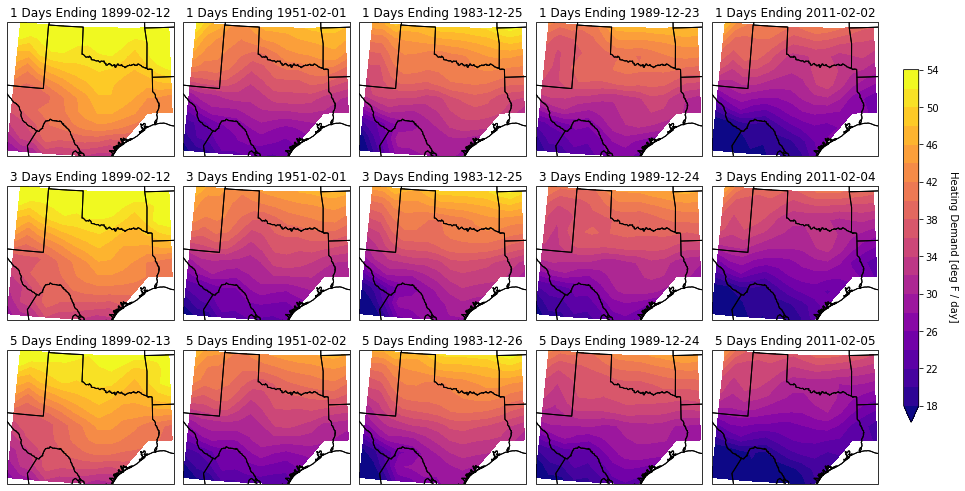

In [14]:
fig, axes = plt.subplots(
    nrows=len(DURATIONS),
    ncols=len(bk_EVENTS),
    figsize=(14, 7),
    subplot_kw=dict(projection=map_proj),
    sharex=True,
    sharey=True,
)

for col, event in enumerate(bk_EVENTS):
    for row, dur in enumerate(DURATIONS):
        ax = axes[row, col]
        date = event[row]
        C0 = bk_hdd_land.sel(time=date, lag=dur).plot.contourf(ax=ax, **bk_plot_kw)
        ax.set_title(f"{dur} Days Ending {date}")
        ax.add_feature(STATES)
        ax.add_feature(COASTLINE)

# Add  color bars
fig.canvas.draw()
fig.tight_layout()
fig.subplots_adjust(right=0.875)
cax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(C0, cax=cax)
cbar.set_label("Heating Demand [deg F / day]", rotation=270)
cbar.ax.get_yaxis().labelpad = 20

plt.savefig(figname("historic_events_bk.pdf"))
plt.show()

Wow, that 1899 event looks to have been crazy!
And in this data set the 2011 event looks even more trivial.

### Note on data

Why the different colorbars?
The two data sets have very different estimates of heating degree days.
Mostly this is due to methodology:

- For Berkeley Earth, we download daily minimum and maximum temperatures. Then we calculate
$$\text{HDD} = \frac{T_{min} + T_{max}}{2} $$
- For ERA5, we download hourly temperatures. Then we calculate
$$\text{HDD} = \sum_{h=0}^{24} \left[ \frac{T_h}{24} \right] $$

These two methods give different estimates of heating degree days, which we can visualize by looking at a single winter (say 2018-19):

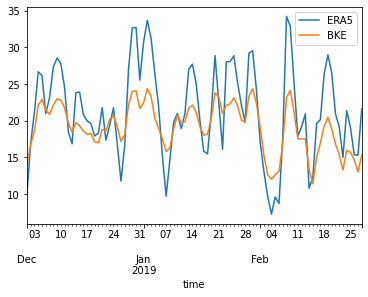

In [15]:
bk_dly = (
    bk_hdd_land.sel(lag=1)
    .mean(dim=["lat", "lon"])
    .to_dataframe()
    .rename(columns={"HDD": "BKE"})[["BKE"]]
)
era_dly = (
    hdd_land.sel(lag=1)
    .mean(dim=["lat", "lon"])
    .to_dataframe()
    .rename(columns={"HDD": "ERA5"})[["ERA5"]]
)
daily = era_dly.join(bk_dly, how="inner").dropna()
daily["2018-12-01":"2019-02-28"].plot()
plt.show()

Fortunately, the correlation is quite high

In [16]:
daily.corr()

,ERA5,BKE
ERA5,1.000000,0.891575
BKE,0.891575,1.000000


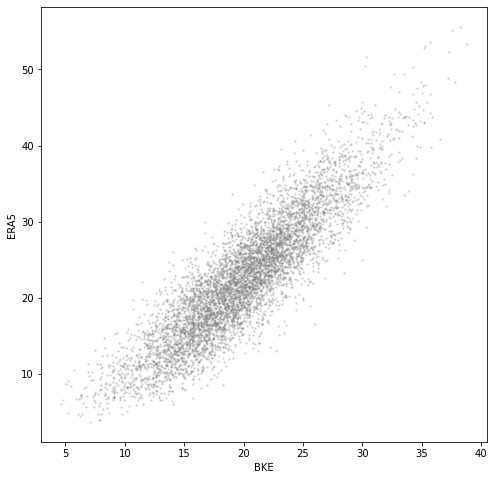

In [17]:
daily.plot.scatter(x="BKE", y="ERA5", alpha=0.25, s=2, c="gray", figsize=(8, 8))
plt.show()

As we shall see in the next notebook, the return periods that these different data sets yield are also quite similar.

REMEMBER:

* Be extremely cautious when comparing across data sets
* Methods of calculating HDD give different results
* Broad findings are similar between the two data sets
* We should interpret the 1899 event with great caution, as data was not consistent. However, the Great Blizzard of 1899 is a thing: https://en.wikipedia.org/wiki/Great_Blizzard_of_1899